# Zeigler-Nichols Tuning Algorithms

Based on empirical observations of PID tuning strategies for process control, Zeigler and Nichols have proposed two methods of choosing the first-pass settings for PID compensators. The methods only need measured system responses and are generally applicable to type 0 systems of any order that are commonly found in process control applications (i.e. control of level, temperature, pressure, flow, etc.). 

**Lecturer**

Set up MATLAB

In [2]:
cd matlab
pwd
clear all
imatlab_export_fig('print-svg')  % Static svg figures.
format compact

Error using cd
Unable to change current folder to '/Users/eechris/Documents/code/src/github.com/cpjobling/eglm03-textbook/04/1/matlab/matlab' (Name is nonexistent or not a folder).


## Step Response Method

Zeigler-Nichols' step response method will work on any system that has an 
open-loop step response that is an essentially critically or overdamped damped 
character like that shown in Figure 1.


![Open-loop step response for a typical process control system](images/fig1.png)
**Figure 1: Open-loop step response for a typical process control system**

From this response it is necessary to determine only two parameters. 

* The slope $R$ of the tangent to the steepest part of the rising edge. 
* The "apparent dead-time" $L$ (which is the intersection of the tangent with the time axis).

Given that $a = RL$, the PID parameters are then tuned according to Table 1. 

**Table 1 Tuning parameters for Zeigler-Nichols' time response method**

| Type | $K_{\mathrm{prop}}$ | $T_I$ | $T_D$  |
|------|---------------------|-------|--------|
| P    | 1/*a*               |       
| PI   | 0.9/*a*             | 3*L*  |        |    
| PID  | 1.2/*a*             | 2*L*  | 0.5*L* |
  

Provided that the open-loop response is stable, it is possible to measure the apparent time constant $T$. For a second order system it can be shown that the settling time (to 98% of the final value) of an overdamped system is approximately $4T$. We thus take this as an approximation for any higher-order system that has the general shape indicated in Figure 1. Thus

$$T\approx \frac{T_s }{4}.$$                                      

Given the apparent time constant, Zeigler-Nichols' step response tuning 
method works reasonably well for

$$0.15\le \frac{L}{T}\le 0.6.$$                                .

Under these conditions, the choice of tuning parameters indicated in Table 1 would give a closed-loop system with good load-disturbance rejection properties. Zeigler-Nichols tuning methods, however, tend to produce systems whose transient response is rather oscillatory and so will need to be tuned further prior to putting the system into closed-loop operation.

## Ultimate sensitivity method

This tuning algorithm works for type 0 systems that have order > 2. It can also be adapted to work in auto-tuning implementations of PID compensators<sup>2</sup>. The tuning method relies on being able to find the gain at which the Nyquist response crosses the critical point or equivalently when the root locus crosses the imaginary axis. It can be found experimentally, but requires that the gain be increased in closed-loop operation until the response becomes a sustained oscillation. This may be a dangerous mode of operation in some process control applications! The gain at which the system becomes marginally stable is called $K_u$. The period of oscillation of this frequency is $T_u$. 

Once these two parameters are known, the PID parameters are selected according to Table 2. 

**Table 2 Tuning parameters for Zeigler-Nichols' ultimate sensitivity method**

| Type | $$K_{\mathrm{prop}}$$ | $$T_I$$     | $$T_D$$   |
|------|-----------------------|-------------|-----------|
| P    | 0.5 *K<sub>u</sub>* |
| PI   | 0.45 *K<sub>u</sub>*         | *T<sub>u</sub>*/1.2 |           |    
| PID  | 0.6 *K<sub>u</sub>*          | *T<sub>u</sub>*   | *T*<sub>u</sub>/8 | 

The static gain for the open-loop system is

$$K_p=\left.G(s)H(s)\right|_{s=0}$$            

The ultimate sensitivity tuning method works well if:

$$2<K_p\,K_u<20$$ 

but again, the closed-loop response tends to be somewhat under-damped.

## Examples

To illustrate the application of the Zeigler-Nichols tuning rules we take 
the plant:

$$\begin{equation}G(s)=\frac{6}{(s+1)(s+2)(s+3)}\end{equation}$$                          .                                 

In [2]:
G = zpk([],[-1;-2;-3],6)


G =
 
          6
  -----------------
  (s+1) (s+2) (s+3)
 
Continuous-time zero/pole/gain model.



The feedback:

In [3]:
H=1; 

Loop transfer function:

In [4]:
GH=G*H;

### Time response method
The open-loop step response of the system is

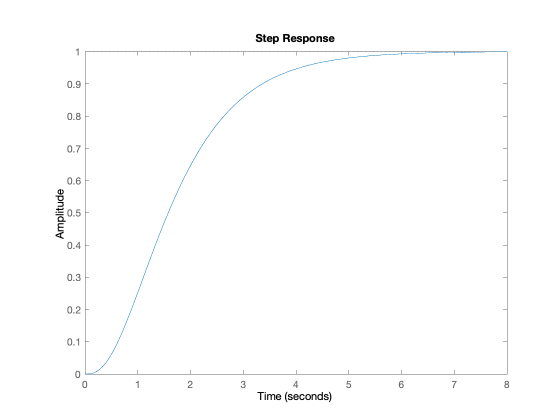

In [5]:
step(GH)  

From this figure, we determine that settling time:

In [6]:
Ts = 4.95; 

so

In [7]:
T = Ts/4; 

The tangent seems to cross the time axis at 

In [8]:
cmin = 0; tmin = 0.42; 

and the final value at

In [9]:
cmax=1; tmax = 2.674;

Let us add this information to the step response:

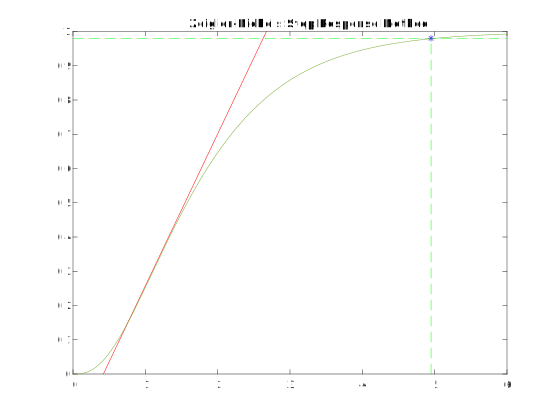

In [10]:
[c,t]=step(GH,6);
plot([tmin,tmax],[cmin,cmax],'r-'),axis([0,6,0,1]),hold on,...
plot([0,6],[0.98,0.98],'g--',[Ts,Ts],[0,0.98],'g--',[Ts],[0.98],'b*'),...
title('Zeigler-Nichols Step Response Method'),plot(t,c),hold off  

The slope of the tangent is

In [11]:
R = (cmax-cmin)/(tmax-tmin)  

R =
    0.4437


The parameter

In [12]:
L = tmin;
L/T 

ans =
    0.3394


is in the rquired range so

In [13]:
a=R*L;   

and the PID parameters are

In [14]:
Kprop = 1.2/a; Ti = 2*L; Td = 0.5*L;  

we construct the PID compensator

In [15]:
Prop = tf(1,1);
Integ = tf(1,[Ti,0]);
Deriv = tf([Td,0],1);
PID1 = Kprop*(Prop + Integ + Deriv)  


PID1 =
 
  1.136 s^2 + 5.41 s + 6.44
  -------------------------
           0.84 s
 
Continuous-time transfer function.



In [16]:
PID1z = zpk(PID1) 


PID1z =
 
  1.3524 (s+2.381)^2
  ------------------
          s
 
Continuous-time zero/pole/gain model.



Let us examine the root-locus. The closed-loop poles are:

In [17]:
Gc1 = feedback(PID1*G,H);
[poles,zeros,gain]=zpkdata(Gc1,'v');  

So the root-locus (with closed-loop poles superimposed)

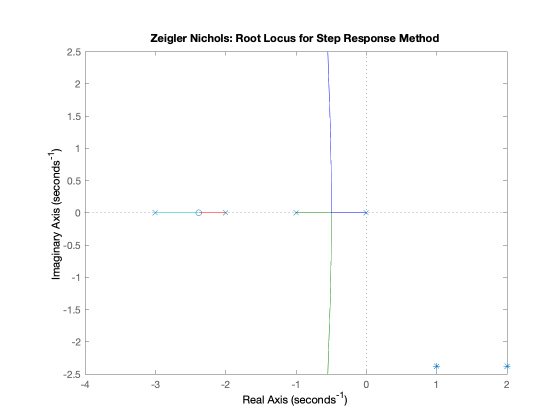

In [18]:
rlocus(PID1*GH),hold on,plot(poles,'*'),...
    title('Zeigler Nichols: Root Locus for Step Response Method'),hold off  

and the step response

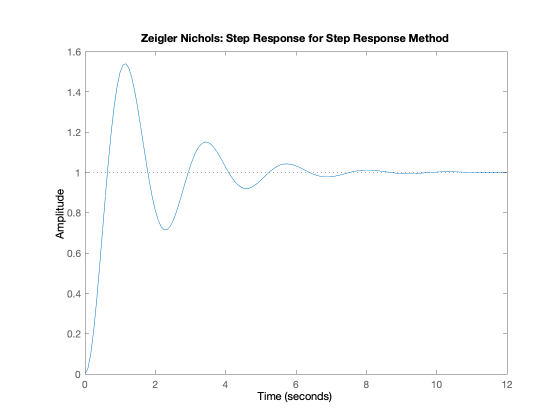

In [19]:
step(Gc1),title('Zeigler Nichols: Step Response for Step Response Method')  

### Ultimate sensitivity method

The open-loop transfer response of the system is $KG(s)H(s)$. We use the Routh-Hurwitz 
criterion for determine the "ultimate" gain _Ku_.

The closed-loop transfer function is:

$$\begin{equation}G_c(s)=\frac{6K}{s^3+6s^2+11s+6(1+K)}.\end{equation}$$     .                            

So the closed-loop characteristic equation is:

$$\begin{equation}s^3+6s^2+11s+6(1+K)=0.\end{equation}$$

The routh array is

$$\begin{array}{*{20}{c}}  
\mathrm{Order}&| & {}&{} \\
\hline  
s^3 &| & 1&{11} \\   
s^2 &| & 6&{6(1 + K)} \\
s^1 &| & {10 - K}&{} \\
s^0 &| & {6(1 + K)}&{} 
\end{array}$$

So the ultimate gain  $K_u=10$.  

When $K = K_u$ the $s_1$ row is zero and the previous row represents a 
factor of the characteristic equation. Hence

$$ 6{s^2} + 6(1 + K) = 0 \\
6{s^2} + 66 = 0 \\
{s^2} =  - 11 \\
s =  \pm j\sqrt {11}$$                             

The ultimate frequency and ultimate period:

$$\omega_u=\sqrt{11}$$                                       

In [20]:
Ku = 10; Tu = 2*pi/sqrt(11);  

To check the validity of this design:

In [21]:
Kp = dcgain(GH)
Kp*Ku  

Kp =
     1
ans =
    10


... which is in the suggested range.

The PID parameters are

In [22]:
Kprop = 0.6*Ku; Ti = Tu/2; Td = Tu/8;  

We again construct the PID compensator

In [23]:
Prop = tf(1,1);
Integ = tf(1,[Ti,0]);
Deriv = tf([Td,0],1);
PID2 = Kprop*(Prop + Integ + Deriv)  
PID2z = zpk(PID2)  


PID2 =
 
  1.346 s^2 + 5.683 s + 6
  -----------------------
         0.9472 s
 
Continuous-time transfer function.


PID2z =
 
  1.4208 (s+2.111)^2
  ------------------
          s
 
Continuous-time zero/pole/gain model.



Let us examine the root-locus. The closed-loop poles are:

In [24]:
Gc2 = feedback(PID2*G,H);
[poles,zeros,gain]=zpkdata(Gc2,'v');  

So the root-locus (with closed-loop poles superimposed)

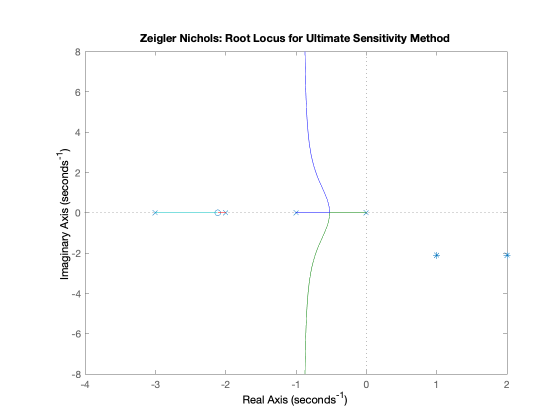

In [25]:
rlocus(PID2*GH),hold on,...
    plot(poles,'*'),...
    title('Zeigler Nichols: Root Locus for Ultimate Sensitivity Method'),hold off  

and the step response

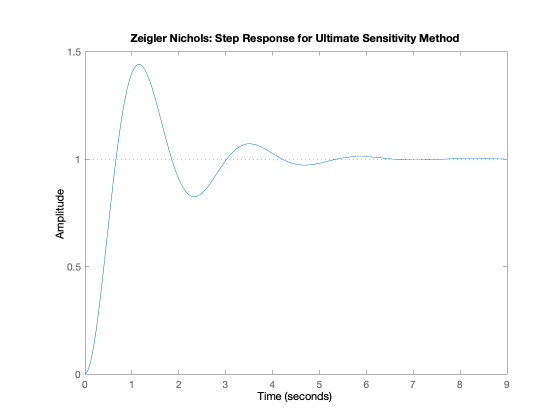

In [26]:
step(Gc2),title('Zeigler Nichols: Step Response for Ultimate Sensitivity Method')  

## Discussion

Comparison of the two designs:

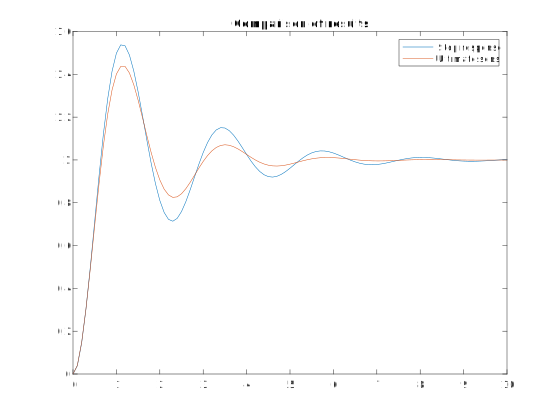

In [27]:
[y1,t1]=step(Gc1,10);
[y2,t2]=step(Gc2,10);
plot(t1,y1,t2,y2),legend('Step response','Ultimate sens.'),...
    title('Comparison of results')  

There is actually very little difference in these two responses. We might choose the result of the ultimate sensitivity as it has a slightly lower peak overshoot. However, it is likely that we can do much better by taking these results as a staring point. 

## Footnotes

[1] Integral action is hardly ever added to systems of type 1 or greater. The additional pole at the origin is usually extremely destabilising.

[2] An auto-tuner is a PID compensator that can choose its own parameters. It is naturally a digital device and consists of a microcontroller with some built-in tuning algorithms. Such devices are available commercially.

## Resources

An executable version of this document is available to download as a MATLAB Live Script file [zeigler.mlx](matlab/zeigler.mlx).